# Задание 3

## Задача 1 5 баллов
- Напишите токенайзенр на основе BPE, используя претокенизацию и специальные токены. Можете использовать паттерны претокенизации открытых моделей, указав источник.
- Обучите свой токенизатор на своем корпусе, токенизируйте тексты, не совпадающие с использованным для обучения.
- Определите коэффициент сжатия (число токенов к количеству байт/символов), среднее количество токенов на слово, среднее количество токенов на слово для топ 10% частотных слов. Ответьте на вопрос, отличается ли эффективность для разных доменов?
- Постройте кривую: размер словаря vs compression ratio
- Определите, какая часть токенов не использовалась ни разу при токенизации [корпуса стихотворений Пушкина](https://dataverse.pushdom.ru/dataset.xhtml?persistentId=doi:10.31860/openlit-2023.8-C005)

In [ ]:
!unzip -q /content/dataverse_files.zip -d /content
!rm -rf /content/dataverse_files.zip

In [ ]:
!unzip -q /content/texts.zip -d /content/texts
!rm -rf /content/texts.zip

In [ ]:
import os
import glob
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, callbacks

from tokenizers import Tokenizer, pre_tokenizers, normalizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder

from sklearn.model_selection import train_test_split

In [ ]:
def load_texts(texts_dir: str = '/content/texts') -> List[Tuple[str, str]]:
    files = glob.glob(os.path.join(texts_dir, '**', '*.txt'), recursive=True)
    rows = []
    for p in files:
        try:
            with open(p, 'r', encoding='utf-8') as f:
                txt = f.read()
        except Exception:
            with open(p, 'r', encoding='cp1251', errors='ignore') as f:
                txt = f.read()
        rows.append((p, txt))
    return rows

In [ ]:
texts = load_texts('/content/texts')
print('Найдено txt файлов:', len(texts))

Найдено txt файлов: 913


In [ ]:
paths = [p for p, t in texts]
train_paths, heldout_paths = train_test_split(paths, test_size=0.2, random_state=42)
print('train files:', len(train_paths), 'heldout files:', len(heldout_paths))

train files: 730 heldout files: 183


In [ ]:
def prepare_training_files(file_paths: List[str], out_dir: str = '/content/bpe_training') -> List[str]:
    """Слипает тексты в несколько файлов"""
    os.makedirs(out_dir, exist_ok=True)

    out_files = []
    joint = os.path.join(out_dir, 'train_corpus.txt')
    with open(joint, 'w', encoding='utf-8') as wf:
        for p in file_paths:
            with open(p, 'r', encoding='utf-8', errors='ignore') as rf:
                wf.write(rf.read())
                wf.write('\n')
    out_files.append(joint)
    return out_files

In [ ]:
train_files = prepare_training_files(train_paths)
print('Training files prepared:', train_files)

Training files prepared: ['/content/bpe_training/train_corpus.txt']


In [ ]:
def train_bpe(tokenizer_path: str, files: List[str], vocab_size: int, special_tokens: List[str] = None) -> Tokenizer:
    """Обучает BPE-токенизатор с ByteLevel"""
    if special_tokens is None:
        special_tokens = ['<pad>', '<s>', '</s>', '<unk>', '<mask>']
    bpe_model = BPE()
    tokenizer = Tokenizer(bpe_model)
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
    tokenizer.decoder = ByteLevelDecoder()
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
    tokenizer.train(files, trainer)
    os.makedirs(os.path.dirname(tokenizer_path), exist_ok=True)
    tokenizer.save(tokenizer_path)
    return tokenizer

In [ ]:
def tokenize_files(tokenizer: Tokenizer, file_paths: List[str]) -> Dict[str, List[int]]:
    """Токенизирует список файлов, возвращает mapping path->list_of_ids"""
    res = {}
    for p in file_paths:
        with open(p, 'r', encoding='utf-8', errors='ignore') as f:
            txt = f.read()
        enc = tokenizer.encode(txt)
        res[p] = enc.ids
    return res

def compute_metrics(tokenizer: Tokenizer, tokenized: Dict[str, List[int]]) -> dict:
    total_tokens = sum(len(v) for v in tokenized.values())
    total_bytes = 0
    total_chars = 0
    for p in tokenized:
      with open(p, 'rb') as f:
          b = f.read()
      total_bytes += len(b)
      with open(p, 'r', encoding='utf-8', errors='ignore') as f:
          s = f.read()
          total_chars += len(s)
    tokens_per_byte = total_tokens / total_bytes if total_bytes else None
    tokens_per_char = total_tokens / total_chars if total_chars else None
    return {
        'total_tokens': total_tokens,
        'total_bytes': total_bytes,
        'total_chars': total_chars,
        'tokens_per_byte': tokens_per_byte,
        'tokens_per_char': tokens_per_char
    }

def avg_tokens_per_word(tokenizer: Tokenizer, file_paths: List[str]) -> Tuple[float, float, pd.Series]:
    """Вычисляет среднее токенов на слово для всех слов и для топ-10% частотных слов"""
    from collections import Counter
    word_counter = Counter()
    word_token_counts = Counter()
    for p in file_paths:
        with open(p, 'r', encoding='utf-8', errors='ignore') as f:
            s = f.read()
        words = s.split()
        enc = tokenizer.encode(s)
        ids = enc.ids
        for w in words:
            w_enc = tokenizer.encode(w)
            word_counter[w] += 1
            word_token_counts[w] += len(w_enc.ids)
    dfw = pd.DataFrame({'word': list(word_counter.keys()),
                        'count': list(word_counter.values()),
                        'tokens': [word_token_counts[w] for w in word_counter.keys()]})
    dfw['tokens_per_occurrence'] = dfw['tokens'] / dfw['count']
    avg_all = (dfw['tokens'] / dfw['count']).mean()
    cutoff = np.percentile(dfw['count'], 90)
    top = dfw[dfw['count'] >= cutoff]
    avg_top10 = (top['tokens'] / top['count']).mean()
    return avg_all, avg_top10, dfw.sort_values('count', ascending=False)

In [ ]:
vocab_sizes = [2000, 5000, 10000, 20000, 40000]
results = []
tokenizer_dir = '/content/tokenizers'
os.makedirs(tokenizer_dir, exist_ok=True)

In [ ]:
for vs in vocab_sizes:
    print('\n--- Training tokenizer with vocab_size=', vs)
    tpath = os.path.join(tokenizer_dir, f'bpe_{vs}.json')
    tok = train_bpe(tpath, train_files, vocab_size=vs)

    tok = Tokenizer.from_file(tpath)
    tokenized = tokenize_files(tok, heldout_paths)
    metrics = compute_metrics(tok, tokenized)
    avg_all, avg_top10, word_stats = avg_tokens_per_word(tok, heldout_paths)
    metrics.update({'vocab_size': vs, 'avg_tokens_per_word': avg_all, 'avg_tokens_per_word_top10pct': avg_top10})
    results.append(metrics)
    print('vocab=', vs, 'tokens_per_byte=', metrics['tokens_per_byte'], 'tokens_per_char=', metrics['tokens_per_char'])



--- Training tokenizer with vocab_size= 2000
vocab= 2000 tokens_per_byte= 0.248217294062972 tokens_per_char= 0.44447984188181444

--- Training tokenizer with vocab_size= 5000
vocab= 5000 tokens_per_byte= 0.21268662135471128 tokens_per_char= 0.38085547659759833

--- Training tokenizer with vocab_size= 10000
vocab= 10000 tokens_per_byte= 0.19410799349366795 tokens_per_char= 0.34758694224655257

--- Training tokenizer with vocab_size= 20000
vocab= 20000 tokens_per_byte= 0.18067416056698035 tokens_per_char= 0.3235311327685636

--- Training tokenizer with vocab_size= 40000
vocab= 40000 tokens_per_byte= 0.1712668467526432 tokens_per_char= 0.30668556456384216


In [ ]:
res_df = pd.DataFrame(results)
display(res_df)

,total_tokens,total_bytes,total_chars,tokens_per_byte,tokens_per_char,vocab_size,avg_tokens_per_word,avg_tokens_per_word_top10pct
0,68365,275424,153809,0.248217,0.444480,2000,3.215753,2.118971
1,58579,275424,153809,0.212687,0.380855,5000,2.673598,1.664791
2,53462,275424,153809,0.194108,0.347587,10000,2.356327,1.497588
3,49762,275424,153809,0.180674,0.323531,20000,2.108284,1.415595
4,47171,275424,153809,0.171267,0.306686,40000,1.920744,1.359325


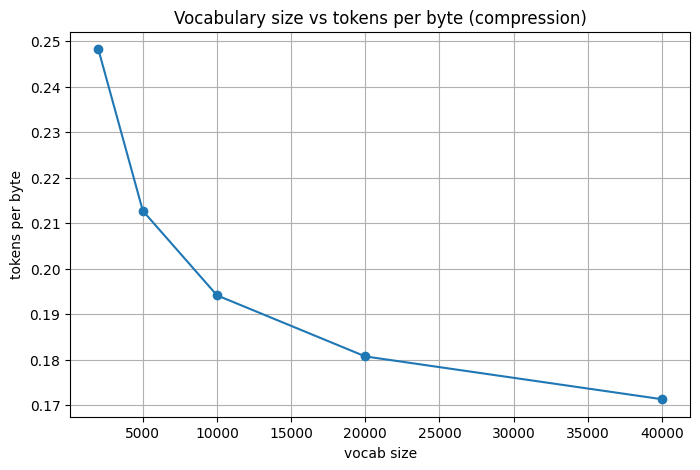

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(res_df['vocab_size'], res_df['tokens_per_byte'], marker='o')
plt.xlabel('vocab size')
plt.ylabel('tokens per byte')
plt.title('Vocabulary size vs tokens per byte (compression)')
plt.grid(True)
plt.show()

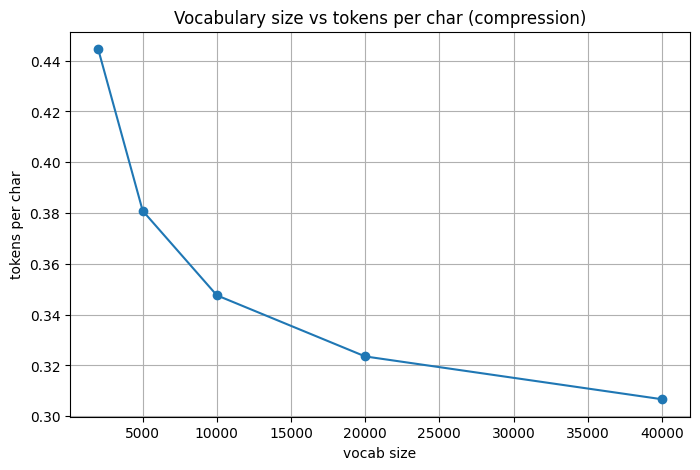

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(res_df['vocab_size'], res_df['tokens_per_char'], marker='o')
plt.xlabel('vocab size')
plt.ylabel('tokens per char')
plt.title('Vocabulary size vs tokens per char (compression)')
plt.grid(True)
plt.show()

In [ ]:
def unused_tokens(tokenizer: Tokenizer, tokenized_ids: Dict[str, List[int]]) -> Tuple[int, int, List[int]]:
    used = set()
    for ids in tokenized_ids.values():
        used.update(ids)
        vocab_size = tokenizer.get_vocab_size()
    all_ids = set(range(vocab_size))
    unused = sorted(list(all_ids - used))
    return len(unused), vocab_size, unused

In [ ]:
best_vs = max(vocab_sizes)
best_tok = Tokenizer.from_file(os.path.join('/content/tokenizers', f'bpe_{best_vs}.json'))
best_tokenized = tokenize_files(best_tok, heldout_paths)
num_unused, vsz, unused_list = unused_tokens(best_tok, best_tokenized)
print('vocab_size=', vsz, 'unused tokens=', num_unused, '(', round(num_unused/vsz*100,2), '%)')

vocab_size= 39034 unused tokens= 30157 ( 77.26 %)


При увеличении размера словаря BPE наблюдается ожидаемое снижение коэффициента сжатия (tokens per byte / tokens per char), а также уменьшение среднего числа токенов на слово. Частотные слова (топ-10%) кодируются более эффективно, чем редкие, что соответствует свойствам алгоритма BPE

Для словаря размером ~40k значительная часть токенов (≈77%) не используется при токенизации отложенного корпуса, что является нормальным для сабсловных токенизаторов, обученных на ограниченном по объёму и домену корпусе

В целом значения метрик находятся в ожидаемом диапазоне для русского языка

## Задача 1.1. 3 балла
Обучите простую модель (можно RNN/n-gram/transformer) с вашим токенизатором.

In [ ]:
tokenizer_path = '/content/tokenizers/bpe_40000.json'
if not os.path.exists(tokenizer_path):
    cand = sorted([p for p in (os.path.join('/content', 'tokenizers') if os.path.isdir('/content/tokenizers') else [])])
    if cand:
        tokenizer_path = cand[0]

In [ ]:
tokenizer = Tokenizer.from_file(tokenizer_path)
vocab_size_full = tokenizer.get_vocab_size()
print('Loaded tokenizer:', tokenizer_path, 'vocab_size=', vocab_size_full)

Loaded tokenizer: /content/tokenizers/bpe_40000.json vocab_size= 39034


In [ ]:
train_file_paths = train_paths
print('Train files count:', len(train_file_paths))

Train files count: 730


In [ ]:
def texts_to_concatenated_ids(paths: List[str], tokenizer: Tokenizer) -> List[int]:
    all_ids = []
    for p in paths:
        with open(p, 'r', encoding='utf-8', errors='ignore') as f:
            txt = f.read()
        enc = tokenizer.encode(txt)
        all_ids.extend(enc.ids)
    return all_ids

In [ ]:
def create_dataset_from_ids(
    ids: List[int],
    seq_len: int = 64,
    stride: int = 64,
    batch_size: int = 64,
) -> tf.data.Dataset:
    """Создает tf.data.Dataset для задач next-token:
    из CONCAT(ids) формирует окна length=seq_len+1, X=[:seq_len], y=[1:].
    stride контролирует перекрытие (stride=seq_len -> непересекающиеся окна).
    """
    ids = np.array(ids, dtype=np.int32)
    total_len = len(ids)
    starts = np.arange(0, max(0, total_len - seq_len), stride)
    X = np.zeros((len(starts), seq_len), dtype=np.int32)
    Y = np.zeros((len(starts), seq_len), dtype=np.int32)
    for i, s in enumerate(starts):
        window = ids[s: s + seq_len + 1]
        if window.shape[0] < seq_len + 1:
            pad = np.full((seq_len + 1 - window.shape[0],), tokenizer.token_to_id('<pad>') or 0, dtype=np.int32)
            window = np.concatenate([window, pad])
        X[i] = window[:-1]
        Y[i] = window[1:]
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=4096, seed=42).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
SEQ_LEN = 64
STRIDE = 64
BATCH_SIZE = 64

In [ ]:
concat_ids = texts_to_concatenated_ids(train_file_paths, tokenizer)
print('Total train token ids length:', len(concat_ids))

Total train token ids length: 152066


In [ ]:
train_ds = create_dataset_from_ids(
    concat_ids,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    batch_size=BATCH_SIZE,
)
print('Train dataset ready. Batches per epoch ~', int(np.ceil((len(concat_ids) / STRIDE) / BATCH_SIZE)))

Train dataset ready. Batches per epoch ~ 38


In [ ]:
unk_id = tokenizer.token_to_id('<unk>')
pad_id = tokenizer.token_to_id('<pad>') or 0

effective_vocab = vocab_size_full
print('Effective vocab used for training:', effective_vocab)

Effective vocab used for training: 39034


In [ ]:
def build_rnn_lm(vocab_size: int, seq_len: int, embed_dim: int = 256, rnn_units: int = 256) -> tf.keras.Model:
    """Построение простой RNN LM: Embedding -> LSTM(+dropout) -> TimeDistributed(Dense(vocab))."""
    inp = layers.Input(shape=(seq_len,), dtype=tf.int32)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False)(inp)
    x = layers.LSTM(rnn_units, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.TimeDistributed(layers.Dense(vocab_size))(x)
    # logits (softmax + loss будет внутри compile)
    model = tf.keras.Model(inp, x)
    return model

In [ ]:
EMBED_DIM = 256
RNN_UNITS = 256

model = build_rnn_lm(effective_vocab, SEQ_LEN, embed_dim=EMBED_DIM, rnn_units=RNN_UNITS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 64, 256)        │     9,992,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 64, 39034)      │    10,031,738 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,549,754 (78.39 MB)

 Trainable params: 20,549,754 (78.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 3
steps_per_epoch = int(np.ceil((len(concat_ids) / STRIDE) / BATCH_SIZE))

ckpt_dir = '/content/rnn_lm_ckpt'
os.makedirs(ckpt_dir, exist_ok=True)
cp_cb = callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, 'model_epoch{epoch:02d}.h5'),
    save_weights_only=False,
    save_best_only=False,
    verbose=1,
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=max(1, steps_per_epoch),
    callbacks=[cp_cb],
)

Epoch 1/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 9.6913 - sparse_categorical_accuracy: 0.1135 
Epoch 1: saving model to /content/rnn_lm_ckpt/model_epoch01.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 453s 12s/step - loss: 9.6663 - sparse_categorical_accuracy: 0.1139
Epoch 2/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 7.3349 - sparse_categorical_accuracy: 0.1306 
Epoch 2: saving model to /content/rnn_lm_ckpt/model_epoch02.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 472s 12s/step - loss: 7.3350 - sparse_categorical_accuracy: 0.1306
Epoch 3/3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 7.1972 - sparse_categorical_accuracy: 0.1293 
Epoch 3: saving model to /content/rnn_lm_ckpt/model_epoch03.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 499s 12s/step - loss: 7.1972 - sparse_categorical_accuracy: 0.1294


In [ ]:
model_path = '/content/rnn_lm_model.keras'
model.save(model_path)
print('Model saved to', model_path)

Model saved to /content/rnn_lm_model.keras


In [ ]:
def sample_with_temperature(logits: np.ndarray, temperature: float = 1.0) -> int:
    probs = np.exp(logits / temperature)
    probs = probs / probs.sum()
    return int(np.random.choice(len(probs), p=probs))

In [ ]:
def generate_text(
    tokenizer: Tokenizer,
    model: tf.keras.Model,
    seed_text: str,
    length: int = 100,
) -> str:
    """Генерация текста автодополнением токенов."""
    enc = tokenizer.encode(seed_text)
    ids = enc.ids.copy()

    for _ in range(length):
        context = (
            ids[-SEQ_LEN:]
            if len(ids) >= SEQ_LEN
            else [pad_id] * (SEQ_LEN - len(ids)) + ids
        )
        inp = np.array([context], dtype=np.int32)

        logits = model.predict(inp, verbose=0)[0, -1]
        next_id = sample_with_temperature(logits, temperature=1.0)
        ids.append(next_id)

    return tokenizer.decode(ids)

In [ ]:
seed = "У лукоморья дуб зелёный"
print('Generated sample:')
print(generate_text(tokenizer, model, seed_text=seed, length=120))

Generated sample:
 У лукоморья дуб зелёный иногда Любусе лили Боль прохладеrivais Конечно� полечу воспламеню вздиолог чернильный клике Стоят двигнется справерною Стекват боготвор отошли Кромтошка сельолож Разинаorta Услышь хранившимиху тороп Шаталась Вилаинучей речам бесподобébraраждает стремятаны поестьейсяатый сцен Гальви чрезвычай лапа Беглербей простерта monumentumлаченаc шлем ВанюшаДитя украш
озможноесу волнах безумные Темиру ужи

 с ль,То выбрал вздыхал глуши яНе; мире богатый бедственныхдин можно смолкнули вас саблю,П поля Елены
О
пНо злата,
 дом людиЗ изменяла завидую хоть!мот предо дверь
 [
 холодный предИ судьбеЛюблю листы румянаН зарой


С обученным BPE-токенизатором была обучена простая LSTM-языковая модель. В процессе обучения наблюдается снижение loss, а генерация демонстрирует правдоподобную кириллическую форму и стиль, но часто теряет смысл и содержит псевдословеса из-за простой архитектуры и ограниченного корпуса. В целом поведение модели соответствует ожиданиям для базовой RNN-LM

## Задача 1.2. 2 балла
Замените токенизатор GPT-2 на ваш (обученный на текстах, содержащих русский язык) и дообучите уже предобученный GPT-2 124M на нем.


In [ ]:
!pip install -q "transformers>=4.30" datasets tokenizers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 29.8 MB/s eta 0:00:00


In [ ]:
import os
import glob
from pathlib import Path
from typing import List, Tuple

import torch
import numpy as np

from transformers import (
    GPT2LMHeadModel,
    PreTrainedTokenizerFast,
    GPT2TokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline,
    AutoModelForCausalLM
)
from tokenizers import Tokenizer
from datasets import Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
hf_tok_obj = Tokenizer.from_file("/content/tokenizers/bpe_40000.json")

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=hf_tok_obj,
    unk_token="<unk>",
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>",
)

In [ ]:
print("Vocab size (new):", tokenizer.vocab_size)
print("Special tokens:", tokenizer.all_special_tokens)

Vocab size (new): 39034
Special tokens: ['<s>', '</s>', '<unk>', '<pad>']


In [ ]:
model_name = "gpt2"  # 124M
model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
orig_tok = GPT2TokenizerFast.from_pretrained("gpt2")

orig_vocab = orig_tok.get_vocab()
new_vocab = tokenizer.get_vocab()

print("orig vocab size:", len(orig_vocab), "new vocab size:", tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

orig vocab size: 50257 new vocab size: 39034


In [ ]:
orig_vs = model.config.vocab_size
new_vs = tokenizer.vocab_size
if new_vs != orig_vs:
    model.resize_token_embeddings(new_vs)
    print(f"Resized embeddings: {orig_vs} -> {new_vs}")

Resized embeddings: 50257 -> 39034


In [ ]:
with torch.no_grad():
    emb = model.get_input_embeddings().weight
    copied = 0
    for tok, new_id in new_vocab.items():
        if tok in orig_vocab:
            old_id = orig_vocab[tok]
            if old_id < emb.size(0) and new_id < emb.size(0):
                emb[new_id].data.copy_(model.get_input_embeddings().weight.data[old_id])
                copied += 1
    print(f"Copied embeddings for {copied} tokens (by exact string match).")

Copied embeddings for 1203 tokens (by exact string match).


In [ ]:
print("Loaded texts count:", len(texts))

Loaded texts count: 913


In [ ]:
ds = Dataset.from_list([{"text": t} for t in texts])
print("Dataset items:", len(ds))

Dataset items: 913


In [ ]:
block_size = 512

In [ ]:
def tokenize_batch(examples):
    # возвращаем input_ids (без паддинга)
    out = tokenizer(examples["text"])
    return out

In [ ]:
tokenized = ds.map(tokenize_batch, batched=True, remove_columns=["text"], desc="Tokenizing")

Tokenizing:   0%|          | 0/913 [00:00<?, ? examples/s]

In [ ]:
def group_texts(examples):
    # конкатенируем все input_ids в длинную последовательность и разбиваем на блоки block_size
    all_ids = sum(examples["input_ids"], [])
    total_len = len(all_ids)
    if total_len < block_size:
        return {"input_ids": [all_ids], "labels": [all_ids.copy()]}
    total_len = (total_len // block_size) * block_size
    chunks = [all_ids[i : i + block_size] for i in range(0, total_len, block_size)]
    return {"input_ids": chunks, "labels": [c.copy() for c in chunks]}

In [ ]:
lm_dataset = tokenized.map(group_texts, batched=True, remove_columns=tokenized.column_names, desc="Grouping")
print("LM dataset size (blocks):", len(lm_dataset))

Grouping:   0%|          | 0/913 [00:00<?, ? examples/s]

LM dataset size (blocks): 422


In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

output_dir = "/content/gpt2_finetuned_customtokenizer"

training_args = TrainingArguments(
    output_dir=output_dir,
    optim="adamw_torch",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=8,
    learning_rate=5e-4,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/tmp/ipython-input-3151442934.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("Trainer ready. Starting training...")
trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print("Saved finetuned model and tokenizer to", output_dir)

Trainer ready. Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,5.749400
200,4.444600


Saved finetuned model and tokenizer to /content/gpt2_finetuned_customtokenizer


In [ ]:
finetuned = GPT2LMHeadModel.from_pretrained(output_dir).to(device)
finetuned_tokenizer = PreTrainedTokenizerFast.from_pretrained(output_dir)

gen = pipeline("text-generation", model=finetuned, tokenizer=finetuned_tokenizer, device=0 if device.type=='cuda' else -1)

prompt = "У лукоморья дуб зелёный"
out = gen(prompt, do_sample=True, top_k=50, top_p=0.95, temperature=0.8, num_return_sequences=1, max_new_tokens=200, repetition_penalty=1.02)
print(out[0]["generated_text"])

Device set to use cpu


У лукоморья дуб зелёныйался;
Тогда буетен в камельке, и что не варит.
Забвенью его и, хоть нет охоты из гузна, право.
Живет на свете я вижу, ни был у берегов,
И с нею на свете на свете и ней
На лицах умереть.
«Прости, — говорит: — он, — молвил ты коня вороного?»
«Не будет тебе вы, гости,господа, —
Не будет тебе вы, гости,господа,
Вотще лишь только по вкусил».
«Он, что за всем там, —
Чтобы объехали весь свет;
Пленбежал и,тоит мы средь толпычится:
За ними гдеа и том и врагом,
Острал восторженной и он,
Сей бабой Бабарихой, —
Блаженство в церковь Балом!»

Вамвечал и в последний раз
Лицо: но сердцу скромно.
А вы


Был заменён стандартный токенизатор GPT-2 на собственный BPE-токенизатор, обученный на русскоязычном корпусе, и выполнено дообучение GPT-2 124M. Модель корректно адаптировалась к новому словарю (loss снизился) и генерирует кириллический текст со стилистическими признаками поэзии, что подтверждает корректность замены токенизатора и процедуры дообучения. Однако, генерирует ещё с артефактами/шумом - для улучшения стоит больше данных или дообучить эмбеддинги дольше

## Задача 2. 12 баллов
Дообучите одну из следующих моделей генерировать анекдоты на русском языке:
- [Qwen-3-0.6B](https://huggingface.co/Qwen/Qwen3-0.6B)
- [Qwen-2.5-0.5B](https://huggingface.co/Qwen/Qwen2.5-0.5B)
- [gemma-3-270m](https://huggingface.co/google/gemma-3-270m)
- [SmolLM-360M](https://huggingface.co/HuggingFaceTB/SmolLM2-360M)

Для этого можете использовать SFT/RL. В качестве исходной модели можно брать Instruct-версию чекпойнта, за базовую версию (только Pretrain) вы получите +1 доп.балл.

Для сдачи этого задания вам необходимо подготовить файл со сгенерированными анекдотами в форммате txt, анекдоты должны находиться на отдельных строках.
Сдача задания будет проходить в виде соревнования-арены в специальном боте. Вам необходимо будет отправить подготовленный файл боту.Внимание! Можно отправить (успешно) только один файл! После небольшой проверки (премодерации) он будет добавлен в пул соревнующихся моделей.
Во время соревнования вы будете получать пары предсказаний и должны будете проголосовать за лучший из них. По количеству голосов будет определяться финальный рейтинг. Чем больше вы сравните анекдотов, тем более честным он будет :)
Соревнование закроется за 2 дня до зачета, защита этого задания будет включать только проверку ноутбуков заочно (без общения).
Для проверки вы должны закоммитить ноутбук c логами генерации, а также скрипты/ноутбуки, использованные для дообучения модели.

Топ 25% получит +4 балла, топ-50% + 3 балла, топ-75% +1 балл

In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers datasets accelerate peft bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.0 MB/s eta 0:00:00


In [7]:
import os
import re
import torch
import random
import pandas as pd

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model

In [3]:
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"

DATA_CSV = "/content/clean_comedy_ru.csv"
PREFIX_FILE = "/content/prefixes.txt"

OUTPUT_DIR = "./joke_lora"
SUBMISSION_FILE = "submission.txt"

MAX_LEN = 256
BATCH_SIZE = 2
GRAD_ACCUM = 8
EPOCHS = 2
LR = 2e-4
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)

In [5]:
df = pd.read_csv(
    DATA_CSV,
    engine="python",
    sep=",",
    quotechar='"',
    escapechar="\\",
    on_bad_lines="skip"
)

df = df.dropna(subset=["text"])
df = df[df["text"].str.len() > 20]
df = df.reset_index(drop=True)

print("Анекдотов:", len(df))
df.head()

Анекдотов: 40837


,text,humour_label
0,Давай ты потратишь на меня лучшие годы своей ж...,0
1,"Все люди двуличны. Первая личность добрая, иск...",1
2,Конь в яблоках и гусь в яблоках - это две прин...,1
3,Беззаботное детство: с трёх до восьми лет дети...,0
4,"Девушки говорят, что вот поплачешь и все как-т...",0


In [98]:
prefixes = []

with open(PREFIX_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        idx, text = line.split(" ", 1)
        prefixes.append((int(idx), text))

print("Префиксов:", len(prefixes))
print(prefixes[:5])

Префиксов: 75
[(1, 'Идёт мужик по лесу'), (2, 'Встречаются два друга'), (3, 'Приходят мужик в бар'), (4, 'Жена говорит мужу'), (5, 'Приходят альфа, бета и гамма в бар')]


In [8]:
def split_joke(text, min_prefix_words=4):
    text = text.strip()

    match = re.split(r"[.!?—,]", text, maxsplit=1)
    if len(match) > 1 and len(match[0].split()) >= min_prefix_words:
        prefix = match[0]
        continuation = text[len(match[0]):].lstrip(" .,!—?")
        return prefix, continuation

    # первые N слов
    words = text.split()
    if len(words) >= min_prefix_words * 2:
        prefix = " ".join(words[:min_prefix_words])
        continuation = " ".join(words[min_prefix_words:])
        return prefix, continuation

    return None, None

In [10]:
pairs = []

for joke in df["text"]:
    prefix, continuation = split_joke(joke)
    if prefix is None:
        continue

    pairs.append({
        "text": f"{prefix} — {continuation}"
    })

dataset = Dataset.from_list(pairs)
dataset[0]

{'text': 'Давай ты потратишь на меня лучшие годы своей жизни — но это будет как-бы мне на день рождения.'}

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [12]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LEN,
        padding="max_length"
    )

dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])

Map:   0%|          | 0/39824 [00:00<?, ? examples/s]

In [13]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [14]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


In [15]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    fp16=True,
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss
50,3.124000
100,3.010000
150,2.969900
200,2.971500
250,2.931600
300,2.971400
350,2.918700
400,2.916700
450,2.909700
500,2.898500


TrainOutput(global_step=4978, training_loss=2.8085568858323304, metrics={'train_runtime': 5105.3507, 'train_samples_per_second': 15.601, 'train_steps_per_second': 0.975, 'total_flos': 4.391730541284557e+16, 'train_loss': 2.8085568858323304, 'epoch': 2.0})

In [104]:
model.eval()

MAX_NEW_TOKENS = 60

results = []

for idx, prefix in prefixes:
    prompt = f"{prefix} — "
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[1]

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_length=input_len + MAX_NEW_TOKENS,
            do_sample=True,
            temperature=0.7,
            top_p=0.85,
            repetition_penalty=1.2,
            no_repeat_ngram_size=5,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    gen_ids = output[0][input_len:]
    text = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
    results.append(f"{idx} {text}")

In [105]:
with open(SUBMISSION_FILE, "w", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

print("Файл:", SUBMISSION_FILE)

Файл: submission.txt


In [106]:
results

['1 10 минут назад у него не было собак. И он решил: вот, это будет нормально! Пойду поговорить с ними. Он подошел к собаке и говорит: - Братишка, я тебя зовёл, а ты мне не ответ',
 '2 - Ты знаешь, что мне сказала? - Нет. - А я так понимаю, ты уже не знаю... - Я тоже не знаю! - Ну иди, а то у меня нет дома... - Не волнуйся, я тебя на море',
 '3 20 лет, ходит в танцевальную студию. Он говорит: - А мне нравится музыка? - Да люблю! - Какой? - Давай попробуем! Ты звони со мной! Скажите',
 '4 — Вчера я была на работе, а он ушел в отпуск. Он не хочет мне дать деньги, чтобы купить себе новый костюм и проковысить фигуру... Муж подумал: Надо бы ему подарить что-нибудь',
 '5 32 часа назад. Группа не знала о их прибытии. Старуха поднимает стаканчик с водой. - Вот у меня кипятка есть. - Нехорошо, не стоит. А что? - У вас нет',
 '6 10-20 минут, а он всё ещё не спит. Вопрос: Что ему делать? - Поговорить с бабушкой! - Скажите, что это за бабушка? - Я её так и называю. Боже,',
 '7 20 лет назад, в детс

В ходе работы я дообучил модель Qwen-2.5-0.5B с помощью LoRA для генерации анекдотов по заданным затравкам. На практике выяснилось, что юмор - это сильно более сложная задача, чем обычная генерация текста: даже после обучения только около 5% ответов можно воспринимать как шутки. Датасет брал отсюда https://github.com/gorovuha/CleanComedy

Это ожидаемо, потому что модель небольшая (0.5B параметров), раньше не видела такие затравки, а сама тема юмора плохо формализуется и сильно зависит от контекста. В обзорах также пишут, что LLM в целом плохо справляются с юмором без явной разметки структуры шутки и человеческой оценки
https://habr.com/ru/companies/mts_ai/articles/911860
https://arxiv.org/pdf/2412.09203
